<a href="https://colab.research.google.com/github/EricEricEricJin/ECE539-Group-Project/blob/master/pred_series_mlp_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__MUST TURN ON HI-RAM__

Aims to develop a MLP that use predict series as input and output the class (speech or singing)

```
[M samples] [N sample]
           |
   marker -|
```
Input shape: (M+N),  
Output shape: (2), categorical

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras

import os
import random
import re

Mounted at /content/drive


In [ ]:
# - Use model to predict
# - Align with marker
# - Sample M before and N after
# - Sample (M+N) inside large-enough intervals !!NEED TO COVER CEC!!
# - Save samples in .npy format

In [ ]:
SAMPLE_RATE = 22050

DIR_NAME = "/content/drive/My Drive/Colab Notebooks/ECE539_Project/"

CHUNK_SAMPLE = 661500 // 5

In [ ]:
# Load model
model = keras.models.load_model(DIR_NAME + f"ms_clf_weights_N={CHUNK_SAMPLE}")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 512, 64, 1)        0         
                                                                 
 normalization (Normalizati  (None, 512, 64, 1)        3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 510, 62, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 508, 60, 64)       18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 254, 30, 64)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 254, 30, 64)       0

In [ ]:
def evaluate_stream(BV, STEP_SIZE):
  # Load audio file and parse marker file
  wav_filepath = DIR_NAME + f"xxm_mixed/{BV}.wav"
  audio_binary = tf.io.read_file(wav_filepath)
  marker = np.loadtxt(
    DIR_NAME + f"xxm_mixed/{BV}.csv",
    delimiter=',')
  marker = marker[:,0] * 3600 + marker[:,1] * 60 + marker[:,2]

  # Decode audio and transform to spectrograms
  audio, _ = tf.audio.decode_wav(audio_binary)
  waveform = tf.squeeze(audio)

  def get_spectrogram(waveform):
      spectrogram = tf.signal.stft(
          waveform, frame_length=255, frame_step=128)
      # removes the phase (we only care about the magnitude)
      spectrogram = tf.abs(spectrogram)
      return spectrogram

  pred_list = []
  model_input_list = []

  for i in range((len(waveform) - CHUNK_SAMPLE) // STEP_SIZE + 1):
    wave_ith = waveform[i * STEP_SIZE : i * STEP_SIZE + CHUNK_SAMPLE]
    model_input_list.append(tf.expand_dims(get_spectrogram(wave_ith), -1))

  # Use model to predict
  input_shape = model_input_list[0].shape
  pred_list = model.predict(tf.reshape(model_input_list, (len(model_input_list), *input_shape)))
  return marker, pred_list

In [ ]:
# # plot out one set for demonstration
# STEP_SIZE = CHUNK_SAMPLE // 2
# marker, pred_list = evaluate_stream("BV15z4y1M7ee", STEP_SIZE)
# pred_1D = pred_list[:,1] - pred_list[:,0]

# start_idx = np.array([int((m-60) * SAMPLE_RATE / STEP_SIZE) for m in marker])
# end_idx = np.array([int((m+90) * SAMPLE_RATE / STEP_SIZE) for m in marker])
# input_size = end_idx[0] - start_idx[0]

# # singings
# singings = np.array([pred_1D[start_idx[i] : end_idx[i]] for i in range(len(marker))])

# # speeches
# speeches = []
# for i in range(len(marker) - 1):
#   for j in range((start_idx[i+1] - end_idx[i]) // input_size):
#     speeches.append(pred_1D[end_idx[i] + j*input_size : end_idx[i] + (j+1)*input_size])
# for i in range((len(pred_1D) - end_idx[-1]) // input_size):
#   speeches.append(pred_1D[end_idx[-1] + i*input_size : end_idx[-1] + (i+1)*(input_size)])
# speeches = np.array(random.sample(speeches, len(marker)))

In [ ]:
BV_list = set([re.findall("BV[0-9a-zA-Z]*", _)[0] for _ in os.listdir(os.path.join(DIR_NAME, "xxm_mixed"))])
BV_list

{'BV15z4y1M7ee',
 'BV1ST411t77z',
 'BV1V84y1e7s9',
 'BV1WN41167kE',
 'BV1bT411S7ck',
 'BV1mu4y1e7oL',
 'BV1rD4y1A7PY',
 'BV1sL411k71J',
 'BV1uN411E7KD',
 'BV1uk4y1F7nv'}

In [ ]:

STEP_SIZE = CHUNK_SAMPLE // 2

for BV in BV_list:
  marker, pred_list = evaluate_stream(BV, STEP_SIZE)
  pred_1D = pred_list[:,1] - pred_list[:,0]

  start_idx = np.array([int((m-60) * SAMPLE_RATE / STEP_SIZE) for m in marker])
  end_idx = np.array([int((m+90) * SAMPLE_RATE / STEP_SIZE) for m in marker])
  input_size = end_idx[0] - start_idx[0]

  # print("start idx", start_idx)
  # print("end idx", end_idx)
  # print("intervals", end_idx-start_idx)
  # print("input size", input_size)

  # singings
  singings = np.array([pred_1D[start_idx[i] : end_idx[i]] for i in range(len(marker))])

  # speeches
  speeches = []
  for i in range(len(marker) - 1):
    for j in range((start_idx[i+1] - end_idx[i]) // input_size):
      speeches.append(pred_1D[end_idx[i] + j*input_size : end_idx[i] + (j+1)*input_size])
  for i in range((len(pred_1D) - end_idx[-1]) // input_size):
    speeches.append(pred_1D[end_idx[-1] + i*input_size : end_idx[-1] + (i+1)*(input_size)])
  speeches = np.array(random.sample(speeches, len(marker)))

  print(BV, "singing", singings.shape, "speech", speeches.shape)
  break
  # save to drive
  # np.save(DIR_NAME + "pred_series/singing/" + f"{BV}.npy", singings)
  # np.save(DIR_NAME + "pred_series/speech/" + f"{BV}.npy", speeches)


97/97 [==============================] - 10s 22ms/step
BV1rD4y1A7PY singing (17, 50) speech (17, 50)


In [ ]:
end_idx[1], start_idx[2]

(472, 578)

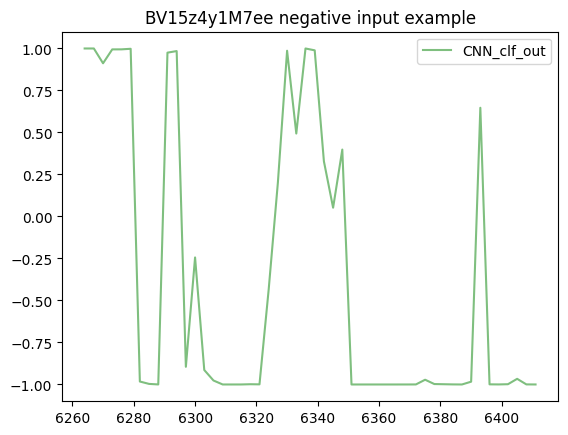

array([6264., 6267., 6270., 6273., 6276., 6279., 6282., 6285., 6288.,
       6291., 6294., 6297., 6300., 6303., 6306., 6309., 6312., 6315.,
       6318., 6321., 6324., 6327., 6330., 6333., 6336., 6339., 6342.,
       6345., 6348., 6351., 6354., 6357., 6360., 6363., 6366., 6369.,
       6372., 6375., 6378., 6381., 6384., 6387., 6390., 6393., 6396.,
       6399., 6402., 6405., 6408., 6411.])

In [ ]:
# Example
speech_time = np.linspace(end_idx[13], end_idx[13]+49, 50) * 3
plt.plot(speech_time, pred_1D[end_idx[13]:end_idx[13]+50], c='g', alpha=0.5, label="CNN_clf_out")
plt.legend()
plt.title("BV15z4y1M7ee negative input example")
plt.show()
speech_time

[316. 317. 318. 319. 320. 321. 322. 323. 324. 325. 326. 327. 328. 329.
 330. 331. 332. 333. 334. 335. 336. 337. 338. 339. 340. 341. 342. 343.
 344. 345. 346. 347. 348. 349. 350. 351. 352. 353. 354. 355. 356. 357.
 358. 359. 360. 361. 362. 363. 364. 365.]


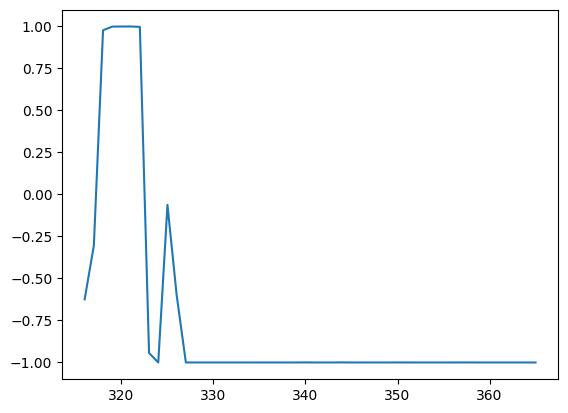

In [ ]:
speech_example = speeches[0]
plt.plot(speech_time, speech_example)
print(speech_time)